In [1]:
# python kernel check
import sys
assert sys.version_info >= (3, 5)

In [17]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary as summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import wandb
import os
import onnx
import onnxruntime
from onnx_tf.backend import prepare
import tensorflow as tf
import tensorflowjs as tfjs

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.set_detect_anomaly(mode=False)

/home/nicolas/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


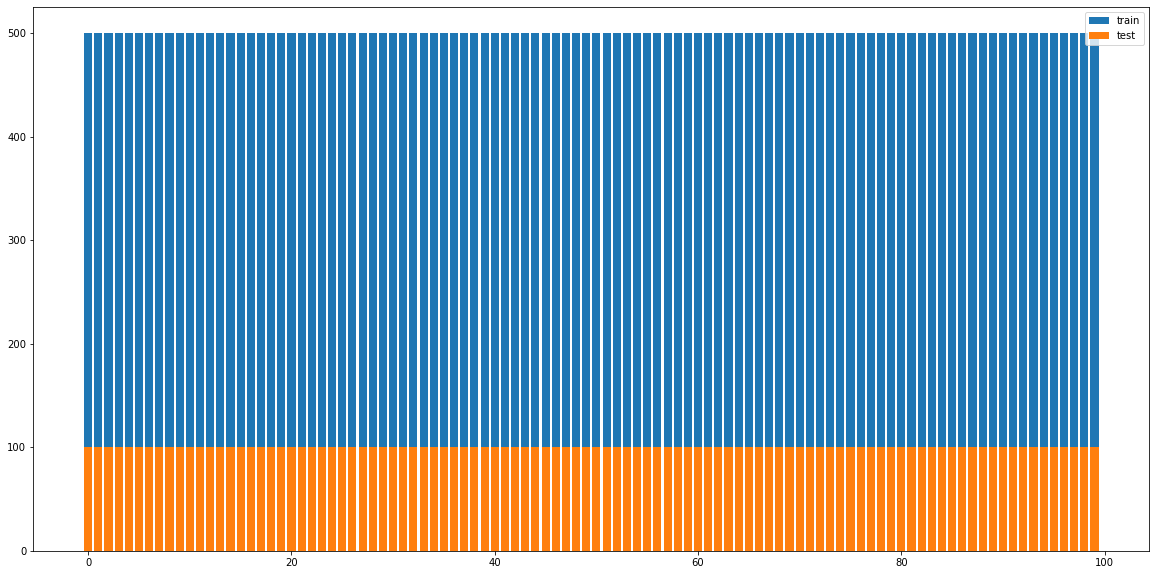

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [37]:
# load the CIFAR 100 dataset

def myTransform(x):
    x = T.ToTensor()(x)
    x=x*255
    # cast to int
    x = x.int()
    # cast to float
    x = x.float()
    x = T.RandomHorizontalFlip()(x)
    return x

BATCH = 256

original_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=myTransform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=T.ToTensor())

percentage = 1.0
train_size = int(percentage * len(original_trainset))
test_size = int(percentage * len(testset))
trainset, _ = torch.utils.data.random_split(original_trainset, [train_size, len(original_trainset) - train_size])
testset, _ = torch.utils.data.random_split(testset, [test_size, len(testset) - test_size])

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=2)


# check distribution of classes
trainset_distribution = np.zeros(100)
for i in range(len(trainset)):
    trainset_distribution[trainset[i][1]] += 1

testset_distribution = np.zeros(100)
for i in range(len(testset)):
    testset_distribution[testset[i][1]] += 1

plt.figure(figsize=(20, 10))
plt.bar(np.arange(100), trainset_distribution, label='train')
plt.bar(np.arange(100), testset_distribution, label='test')
plt.legend()
plt.show()

# get the class names from the dataset
classes = original_trainset.classes
print(classes)


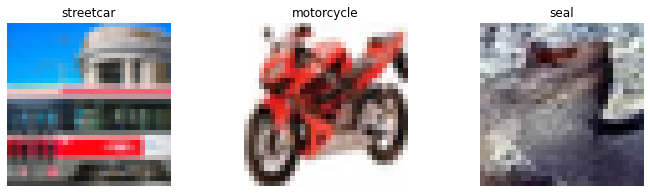

Image shape: torch.Size([3, 32, 32])
Label: 72
Class: seal
max value: tensor(254.)
min value: tensor(0.)
mean value: tensor(119.3643)
std value: tensor(53.2965)


In [39]:
#  display 3 images from the dataset at random

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img, label = trainset[np.random.randint(len(trainset))]
    plt.imshow(img.permute(1, 2, 0)/255)
    plt.title(classes[label])
    plt.axis('off')
plt.show()
print('Image shape:', img.shape)
print('Label:', label)
print('Class:', classes[label])
print('max value:', torch.max(img))
print('min value:', torch.min(img))
print('mean value:', torch.mean(img))
print('std value:', torch.std(img))

In [40]:
#  define the network architecture

class Net(nn.Module):
    def __init__(self, ch1:int, ch2:int, ch3:int, ch4:int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, ch1, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(ch1, ch2, 3)
        self.conv3 = nn.Conv2d(ch2, ch3, 3)
        self.conv4 = nn.Conv2d(ch3, ch4, 3)
        self.lin_shape = ch4*9*9
        self.fc1 = nn.Linear(self.lin_shape, 100)
        # self.fc2 = nn.Linear(100, 100)
        # self.fc3 = nn.Linear(100, 100)
        self.act = nn.SELU()

        self.name = f"Net({ch1}_{ch2}_{ch3}_{ch4})"
        self.debug = False

    def forward(self, x):
        if self.debug: print(x.shape)
        x = self.act(self.conv1(x))
        if self.debug: print(x.shape)
        x = self.pool(x)
        if self.debug: print(x.shape)
        x = self.act(self.conv2(x))
        # if self.debug: print(x.shape)
        # x = self.pool(x)
        if self.debug: print(x.shape)
        x = self.act(self.conv3(x))
        if self.debug: print(x.shape)
        # x = self.pool(x)
        # if self.debug: print(x.shape)
        x = self.act(self.conv4(x))
        if self.debug: print(x.shape)
        x = x.view(-1, self.lin_shape)
        if self.debug: print(x.shape)
        x = self.fc1(x)
        if self.debug: print(x.shape)

        return x

#  define device to use for training
mydev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(6,9,12,3).to(mydev)

net.debug = True
summary.summary(net, (3, 32, 32))
net.debug = False


torch.Size([2, 3, 32, 32])
torch.Size([2, 6, 30, 30])
torch.Size([2, 6, 15, 15])
torch.Size([2, 9, 13, 13])
torch.Size([2, 12, 11, 11])
torch.Size([2, 3, 9, 9])
torch.Size([2, 243])
torch.Size([2, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
              SELU-2            [-1, 6, 30, 30]               0
         MaxPool2d-3            [-1, 6, 15, 15]               0
            Conv2d-4            [-1, 9, 13, 13]             495
              SELU-5            [-1, 9, 13, 13]               0
            Conv2d-6           [-1, 12, 11, 11]             984
              SELU-7           [-1, 12, 11, 11]               0
            Conv2d-8              [-1, 3, 9, 9]             327
              SELU-9              [-1, 3, 9, 9]               0
           Linear-10                  [-1, 100]          24,400
Total params: 26,374
Trainab

In [41]:
#  define the loss function and optimizer and scheduler

total_epochs = 30

criterion = nn.CrossEntropyLoss().to(mydev)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) # SGD generalises better than Adam, but is slower
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(trainloader), epochs=total_epochs)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=0.00001)


In [42]:
# training and testing functions

def step(dataloader, model, loss_fn, optimizer=None, scheduler=None, train=True,verbose=0):
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0
    model.train(train)
    with torch.set_grad_enabled(train):
        with tqdm(total=len(dataloader), disable=verbose<2) as progress_bar:
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(mydev), y.to(mydev)

                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                if train:
                    # Backpropagation
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                running_loss += loss.item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                loss, current = loss.item(), batch * len(X)
                progress_bar.set_postfix_str(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                progress_bar.update(1)
            
            current = batch * len(X)
            progress_bar.set_postfix_str(f"{'Training' if train else 'Testing'} Accuracy: {(100*correct/size):>0.1f}%,\
                Avg loss: {running_loss/len(dataloader):>8f} loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            progress_bar.update(1)
            # if train and scheduler is not None:
                # scheduler.step(running_loss/len(dataloader))

    return (running_loss/len(dataloader), 100*correct/size)



In [44]:
def get_model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
# train loop


def train_loop(dataloader:dict, net, criterion, optimizer, scheduler, total_epochs=1, save=False, verbose=0):
    
    # if verbose = 3: log on wandb
    if verbose == 3:
        wandb.init(project="cifar100edge", name=net.name)
        wandb.watch(net, criterion)
        wandb.log({"nparams":get_model_params(net)})
        # wandb.log({"name":net.name})

    best_test_loss = np.inf

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}

    #  train the network
    #  if verbose < 1: don't show progress bar
    for t in tqdm(range(total_epochs), disable=verbose<1):
        
        #  train step
        train_loss, train_acc = step(dataloader["train"], net, criterion, optimizer, scheduler, train=True, verbose=verbose)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        # history['lr'].append(scheduler.get_last_lr()[0])
        # history['lr'].append(optimizer.param_groups[0]['lr'])
        history['lr'].append(scheduler.get_last_lr()[0])
        #  test step
        test_loss, test_acc = step(dataloader["test"], net, criterion, train=False, verbose=verbose)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        if save and test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(net.state_dict(), f'model.pt')
        if verbose == 3:
            wandb.log({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc, 'lr': scheduler.get_last_lr()[0]})
    
    return history
    
    

In [10]:
#  login to wandb
wandb.login()

wandb: Currently logged in as: colvertyety (theateam). Use `wandb login --relogin` to force relogin


True

In [45]:
#  explore the space of hyperparameters

df = pd.DataFrame(columns=["ch1", "ch2", "ch3", "ch4", "train_loss", "train_acc", "test_loss", "test_acc", "lr", "nparams"])

dataloader = {"train": trainloader, "test": testloader}

for ch1 in [3, 6, 9, 12]:
    for ch2 in [3, 6, 9, 12]:
        for ch3 in [3, 6, 9, 12]:
            for ch4 in [3, 6, 9, 12]:
                net = Net(ch1, ch2, ch3, ch4).to(mydev)
                explore_epochs = 100
                # reset the optimizer and scheduler
                optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=explore_epochs, eta_min=0.00001)
                history = train_loop(dataloader, net, criterion, optimizer, scheduler, total_epochs=explore_epochs, verbose=1)
                df = df.append({"ch1": ch1, "ch2": ch2, "ch3": ch3, "ch4": ch4, "train_loss": history['train_loss'],
                "train_acc": history['train_acc'], "test_loss": history['test_loss'], "test_acc": history['test_acc'],
                "lr": history['lr'], "nparams":get_model_params(net)}, ignore_index=True)
                df.to_csv("df.csv", index=False)
                print(f"ch1: {ch1}, ch2: {ch2}, ch3: {ch3}, ch4: {ch4}, train_loss: {history['train_loss'][-1]}, train_acc: {history['train_acc'][-1]}, test_loss: {history['test_loss'][-1]}, test_acc: {history['test_acc'][-1]}, lr: {history['lr'][-1]}")

df.to_csv("df.csv", index=False)
df

  0%|          | 0/5 [00:00<?, ?it/s]

ch1: 3, ch2: 3, ch3: 3, ch4: 3, train_loss: 4.605864408688667, train_acc: 1.034, test_loss: 4.607009441037722, test_acc: 0.88, lr: 0.005000000000000185


/tmp/ipykernel_7137/1878048743.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"ch1": ch1, "ch2": ch2, "ch3": ch3, "ch4": ch4, "train_loss": history['train_loss'],


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

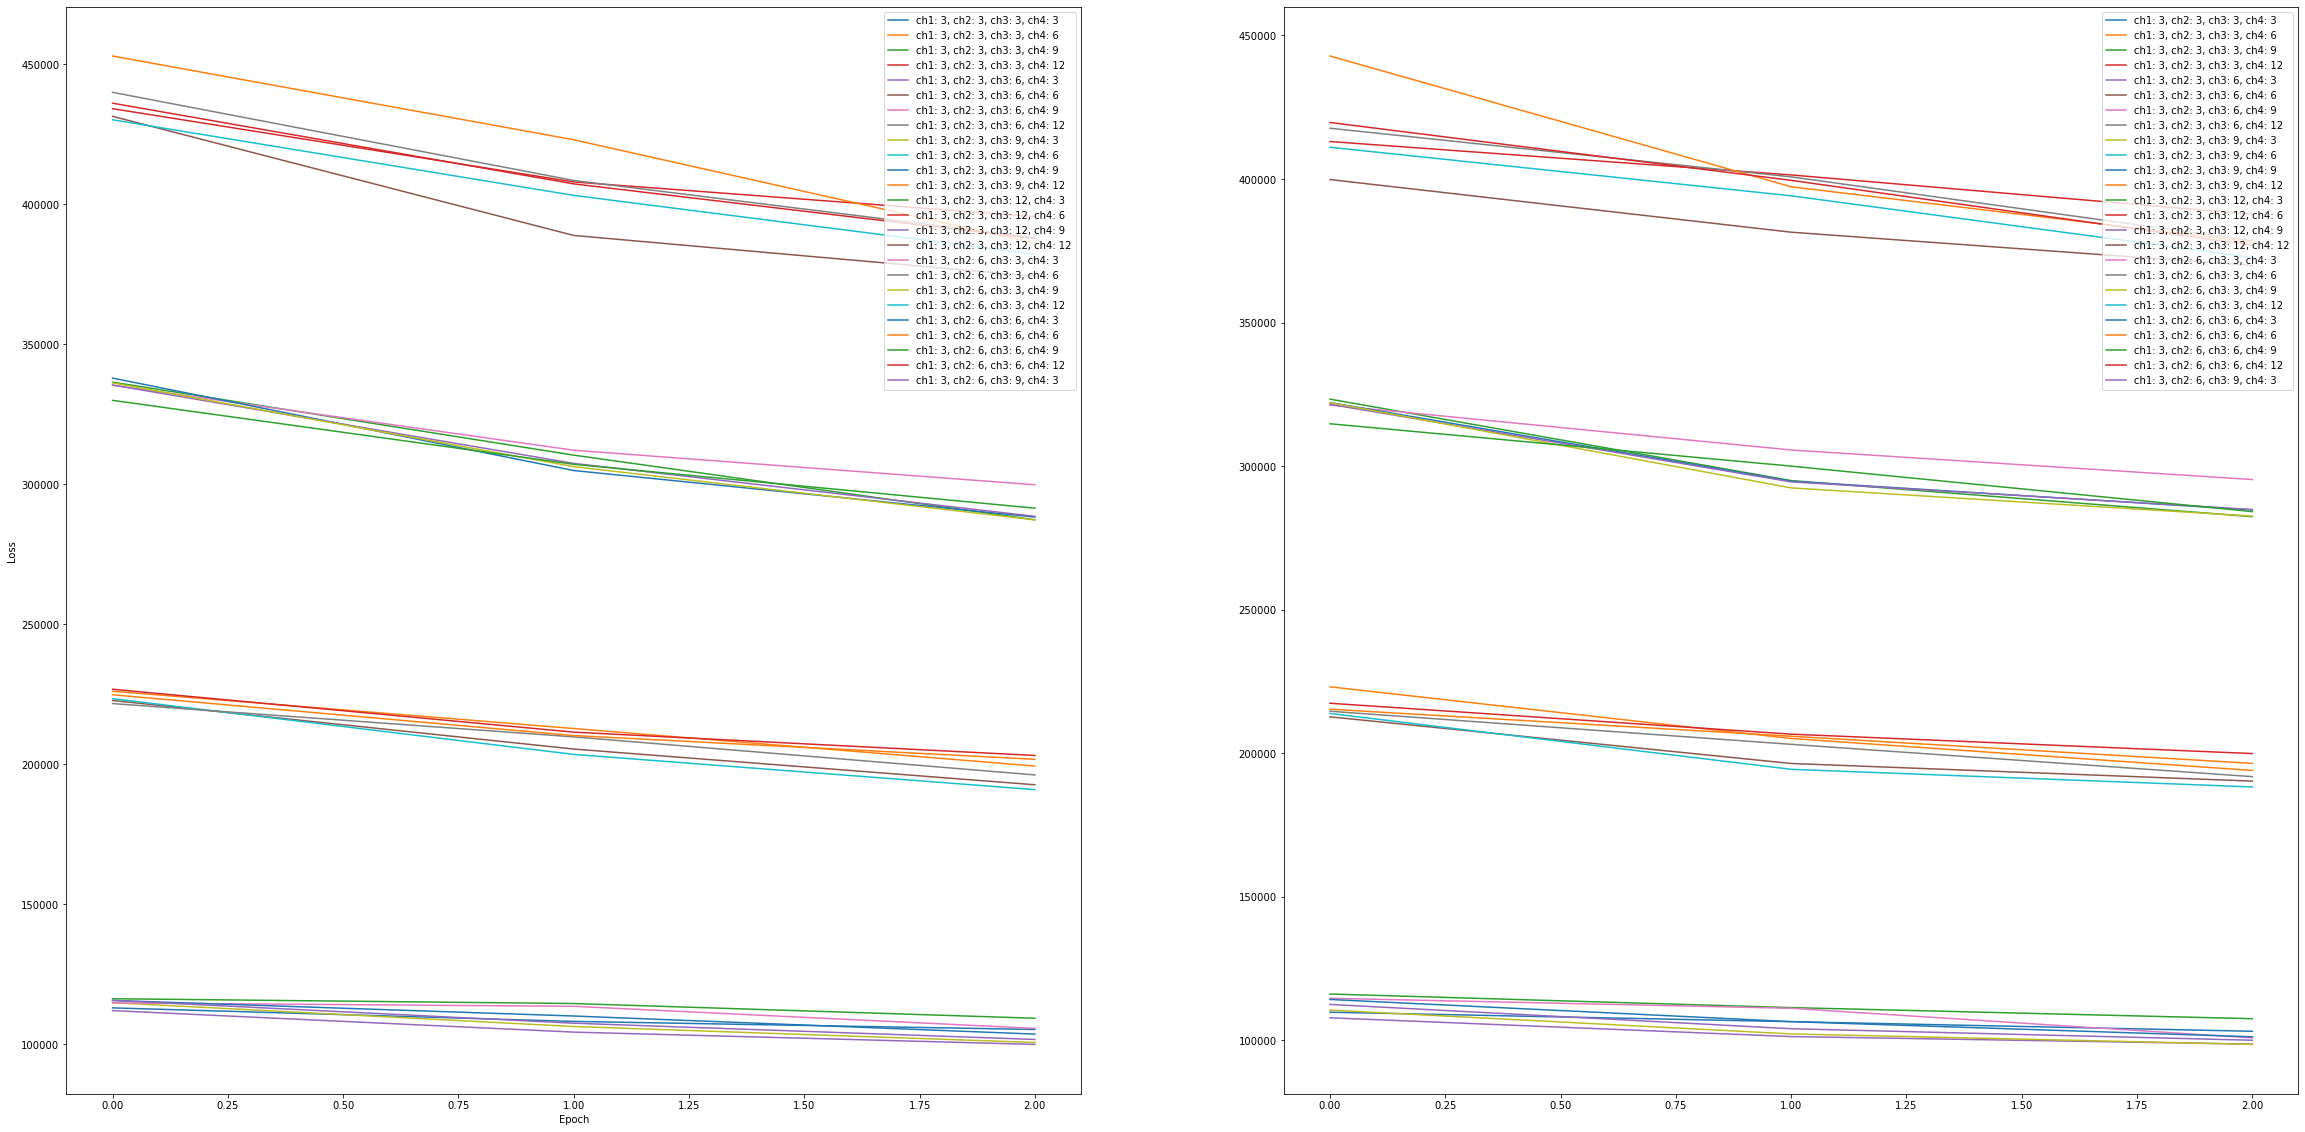

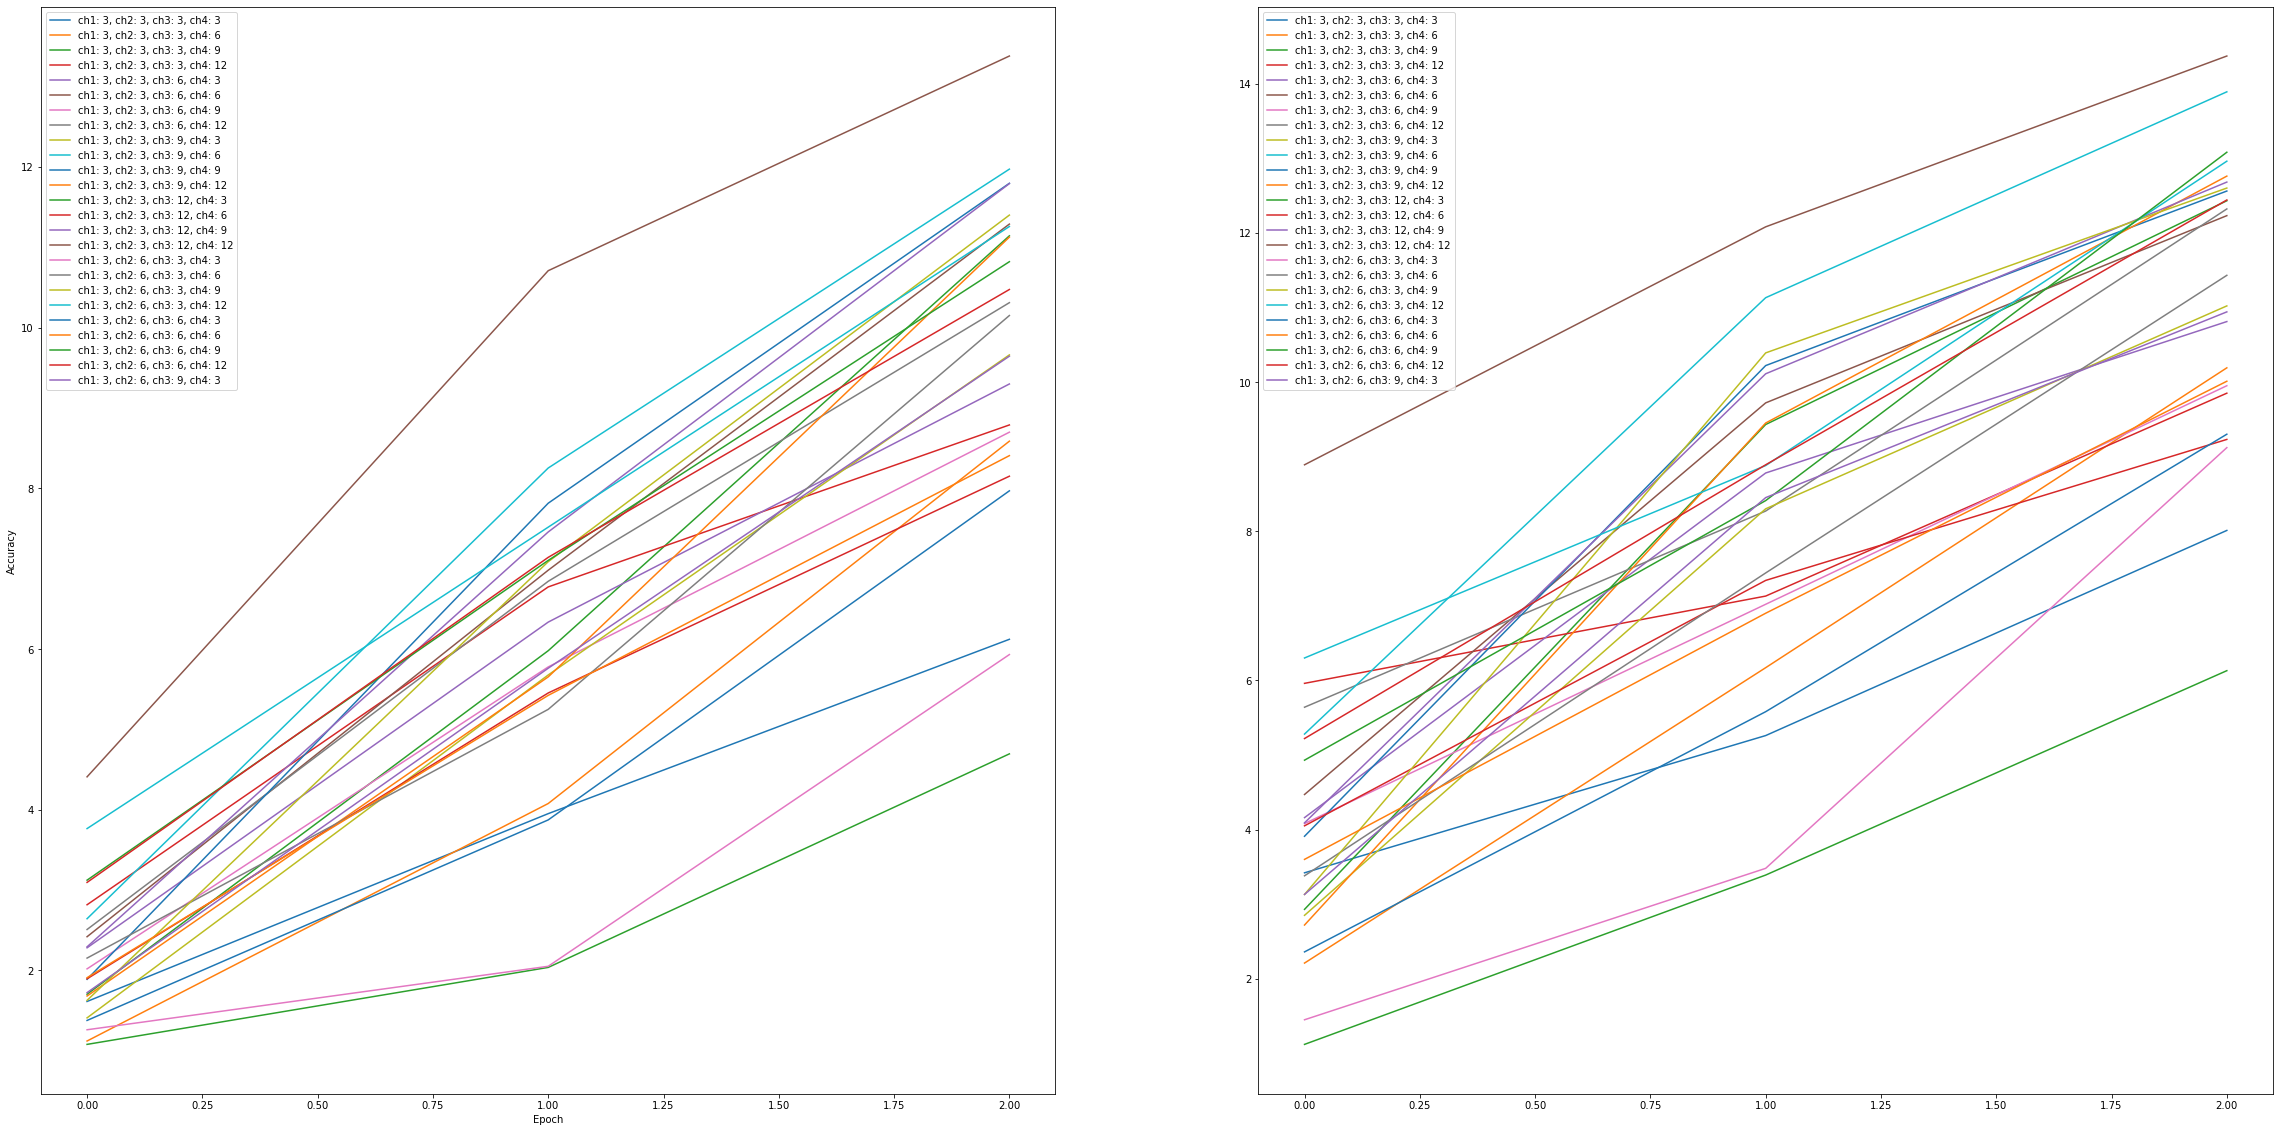

In [12]:
#  graph the results

def parse(l):
    l = l.split("[")[1].split("]")[0].split(", ")
    l = [float(i) for i in l]
    return l


df = pd.read_csv("df.csv")

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
# for each line in the dataframe
for i in range(len(df)):
    # plot the train loss
    new_train_loss = parse(df["train_loss"][i])
    for j in range(len(new_train_loss)):
        new_train_loss[j] = new_train_loss[j]*df["nparams"][i]
    ax[0].plot(new_train_loss, label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
    # plot the test loss
    new_test_loss = parse(df["test_loss"][i])
    for j in range(len(new_test_loss)):
        new_test_loss[j] = new_test_loss[j]*df["nparams"][i]
    ax[1].plot(new_test_loss, label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
# set the legend
ax[0].legend()
ax[1].legend()
# set the labels
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
# for each line in the dataframe
for i in range(len(df)):
    # plot the train accuracy
    ax[0].plot(parse(df["train_acc"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
    # plot the test accuracy
    ax[1].plot(parse(df["test_acc"][i]), label=f"ch1: {df['ch1'][i]}, ch2: {df['ch2'][i]}, ch3: {df['ch3'][i]}, ch4: {df['ch4'][i]}")
# set the legend
ax[0].legend()
ax[1].legend()
# set the labels
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
plt.show()


In [13]:
#  train the network with the best hyperparameters

# find the best hyperparameters
#  for each line in the dataframe
best = {}
best_test_loss = np.inf
for i in range(len(df)):
    # if the test loss is the best
    val = (parse(df["test_loss"][i])[-1])*df["nparams"][i]
    if val < best_test_loss:
        # save the best test loss
        best_test_loss = val
        # save the best hyperparameters
        best = {"ch1": df["ch1"][i], "ch2": df["ch2"][i], "ch3": df["ch3"][i], "ch4": df["ch4"][i]}

if best == {}: raise Exception("No best hyperparameters found")

print(best)

# train the network with the best hyperparameters
net = Net(best["ch1"], best["ch2"], best["ch3"], best["ch4"]).to(mydev)
explore_epochs = 3000
# reset the optimizer and scheduler
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=explore_epochs, eta_min=0.00001)
history = train_loop(dataloader, net, criterion, optimizer, scheduler, total_epochs=explore_epochs, save=True, verbose=1)

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(history["train_loss"], label="train_loss")
ax[0].plot(history["test_loss"], label="test_loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history["train_acc"], label="train_acc")
ax[1].plot(history["test_acc"], label="test_acc")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

#  compute confusion matrix
confusion_matrix = np.zeros((100, 100), dtype=int)
net.eval()
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.to(mydev), labels.to(mydev)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

#  plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(confusion_matrix, cmap="Blues")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.show()



{'ch1': 3, 'ch2': 3, 'ch3': 9, 'ch4': 3}


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/79 [00:00<?, ?it/s]

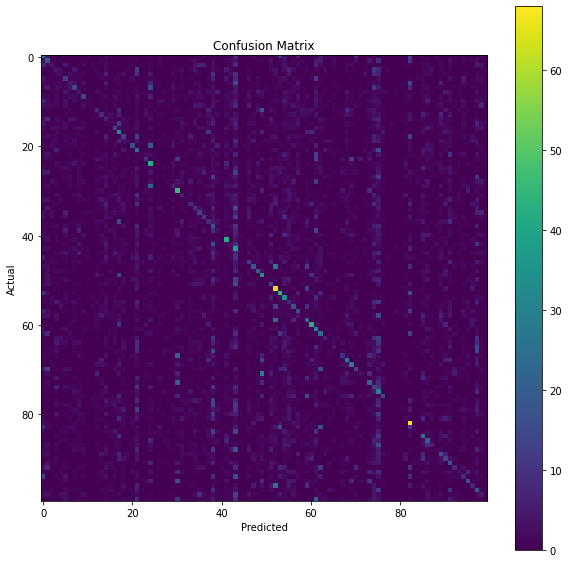

Top 10 classes with the most errors:
index class  (error count) 
1. sunflower (68)
2. oak_tree (65)
3. dolphin (47)
4. orange (44)
5. lawn_mower (43)
6. plain (43)
7. cockroach (42)
8. lion (39)
9. orchid (35)
10. castle (34)


In [14]:
# find the last model
net.load_state_dict(torch.load("model.pt"))
net.eval()

# compute the confusion matrix

confusion_matrix = np.zeros((100, 100), dtype=np.int32)

with torch.no_grad():
    for X, y in tqdm(testloader):
        X, y = X.to(mydev), y.to(mydev)
        pred = net(X)
        pred = pred.argmax(1)
        for i in range(len(y)):
            confusion_matrix[y[i], pred[i]] += 1

# plot the confusion matrix

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#  print the top 10 classes with the most errors

print('Top 10 classes with the most errors:')
print("index class  (error count) ")

for i in range(10):
    max_error = np.max(confusion_matrix)
    max_error_index = np.argmax(confusion_matrix)
    row = max_error_index // 100
    col = max_error_index % 100
    print(f'{i+1}. {classes[row]} ({max_error})')
    confusion_matrix[row, :] = 0
    confusion_matrix[:, col] = 0

In [15]:
#  export the model to onnx
import onnx

dummy_input = torch.randn(1, 3, 32, 32, device=mydev)
torch.onnx.export(net, dummy_input, "model.onnx", verbose=True, input_names=["input"], output_names=["output"])

#  load the model
model = onnx.load("model.onnx")

#  check the model
print(onnx.checker.check_model(model))
#  print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

#  print the model's input and output names
print(model.graph.input)
print(model.graph.output)

#  print the model's input and output shapes
print(model.graph.input[0].type.tensor_type.shape.dim)
print(model.graph.output[0].type.tensor_type.shape.dim)


Exported graph: graph(%input : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(3, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(3, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(3, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(3, strides=[1], requires_grad=1, device=cpu),
      %conv3.weight : Float(9, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv3.bias : Float(9, strides=[1], requires_grad=1, device=cpu),
      %conv4.weight : Float(3, 9, 3, 3, strides=[81, 9, 3, 1], requires_grad=1, device=cpu),
      %conv4.bias : Float(3, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(100, 243, strides=[243, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(100, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/Conv_output_0 : Float(1, 3, 30, 30, strides=[2700, 900, 30, 1],

In [18]:
#  load ot tf
import tensorflow as tf

#  convert the model
tf_rep = prepare(onnx.load("model.onnx"))
tf_rep.export_graph('model.pb')


2022-12-07 18:54:28.305206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2022-12-07 18:54:28.305891: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: model.pb/assets


INFO:tensorflow:Assets written to: model.pb/assets


In [19]:
#  convert the model to a tflite model
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("model.pb")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.qint8]

tflite_model = converter.convert()

#  save the tflite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

2022-12-07 18:54:45.535256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-07 18:54:45.535294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-07 18:54:45.547423: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-07 18:54:45.637505: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: model.pb
2022-12-07 18:54:45.652428: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 115778 microseconds.


In [27]:
#  export the modle to tensorflow js
from tensorflowjs.converters.tf_saved_model_conversion_v2 import convert_tf_saved_model

convert_tf_saved_model("model.pb", "model_js")


Writing weight file model_js/model.json...


2022-12-07 19:00:04.192603: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0


In [26]:
# # load the tflite model
# interpreter = tf.lite.Interpreter(model_path="model.tflite")
# interpreter.allocate_tensors()

# # get the input and output tensors
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# def to_numpy(tensor):
#     #  unbatch the tensor
#     tensor = tensor[0]
#     tensor = tensor.permute(1, 2, 0)
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
# # test the model
# correct = 0
# total = 0
# confusion_matrix = np.zeros((100, 100), dtype=np.int32)
# with torch.no_grad():
#     for data in tqdm(testloader):
#         images, labels = data
#         images, labels = images.to(mydev), labels.to(mydev)
#         interpreter.set_tensor(input_details[0]['index'], to_numpy(images))
#         interpreter.invoke()
#         outputs = interpreter.get_tensor(output_details[0]['index'])
#         _, predicted = torch.max(torch.from_numpy(outputs), 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         for i in range(len(labels)):
#             confusion_matrix[labels[i]][predicted[i]] += 1
        
# print(f"Accuracy: {100 * correct / total}%")

# # plot the confusion matrix
# plt.figure(figsize=(10, 10))
# plt.imshow(confusion_matrix)
# plt.colorbar()
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


  0%|          | 0/79 [00:00<?, ?it/s]

ValueError: Cannot set tensor: Dimension mismatch. Got 3 but expected 4 for input 0.

In [28]:
#  display evolution of file size
import os

print("Size of model.pt: ", os.path.getsize("model.pt"))
print("Size of model.onnx: ", os.path.getsize("model.onnx"))
print("Size of model.tflite: ", os.path.getsize("model.tflite"))
print("Size of model_js/model.json: ", os.path.getsize("model_js/model.json"))

Size of model.pt:  103407
Size of model.onnx:  140780
Size of model.tflite:  107972
Size of model_js/model.json:  11306
